#### For this homework you can get 100 points + 20 bonus points. The bonus points will be counted into your total homework score until you get the maximum homework score, 400.

Copying and pasting other people's code is absolutely prohibited.  I will report to the education team if I find any such cases. Collaboration and discussion is highly encouraged, and feel free to exchange ideas with your classmates, but write your own code please. 

### Question 1: Accuracy and interpretability (10 pts)

a) Describe a real-world prediction problem using urban data for which _interpretability_ of your models and results is essential, and for which it might be preferable to use decision trees rather than random forests.  Argue why this is the case. (3 pts)

b) Describe a real-world prediction problem using urban data for which _accuracy_ is paramount and interpretability may be less important, and for which it might be preferable to use random forests rather than decision trees.  Argue why this is the case. (3 pts)

c) Let's imagine that you want to try to get the best of both worlds (accuracy _and_ interpretability).  So you decide to start by learning a random forest classifier.  Describe at least one way of getting some interpretability out of the model by post-processing.  You could either pick a method from the literature (e.g., Domingos's work on combining multiple models or some method of computing variable importance), or come up with your own approach (doesn't have to be ground-breaking, but feel free to be creative!) (4 pts)

#### A)
In social services, if a predictive model was built to predict when child services may need to intervene and remove a child from a home, it would be beneficial to understand the step-by-step process that leads to this final outcome. If you had good insight into the mechanics of the prediction model, you'd be able to make less extreme interventions at an earlier stage, in order to prevent the more drastic measure of removing a child from a home. Here, interpretability is important.

#### B)
In building a weather model to warn a coastal city of incoming extreme weather, so the city can make necessary preparations, accuracy is the model is extremely important. It's likely that countless factors and levels of complexity would be built into a weather model, and an end user simply wants to know when a city is at risk or not. Interpretability is beyond the scope of the tool, and is likely difficult to achieve with such complexity.

#### C)
A few different approaches... As mentioned in class notes, one could first learn a forest and tune parameters until you're happy with it's accuracy. Then, in order to interpret the results, you build a single tree, and tune that tree to macth the results of your forest - from there, you can use the single tree for interpretability. Alternatively, you can use the notion of 'feature importance' from your forest. The algorithm can output numerical weights that represent the "classifying power" of each feature. With this method, you don't have insight into order and structure of the tree, but generally speaking, high importance places features towards the top of a decision tree.

###  Question 2: Build a tree by hand following exactly the lecture notes. Note that the dataset has been slightly modified, so you will get a different tree than the one shown in the lecture notes. (30 pts + 20 pts)

30 points for parts a, b, c, d, f.
20 bonus points for optional part e.

##### PART A

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import math
import copy

In [15]:
data='MPG, cylinders, HP, weight\ngood, 4, 75, light\nbad, 6, 90, medium\nbad, 4, 110, medium\nbad, 8, 175, weighty\nbad, 6, 95, medium\nbad, 4, 94, light\nbad, 4, 95, light\nbad, 8, 139, weighty\nbad, 8, 190, weighty\nbad, 8, 145, weighty\nbad, 6, 100, medium\ngood, 4, 92, medium\nbad, 6, 100, weighty\nbad, 8, 170, weighty\ngood, 4, 89, medium\ngood, 4, 65, light\nbad, 6, 85, medium\ngood, 4, 81, light\nbad, 6, 95, medium\ngood, 4, 93, light'

In [16]:
# converts a raw data string into clean X and Y matrixes
def process(data_string, numeric, target):
    """
    args:
    numeric: a list of columns names to be coerced to numeric values
    target: column name that represents target labels
    """
    # remove whitespace
    data=",".join(data_string.split(", "))
    # build dataframe header row
    cols = data.splitlines()[0].split(',')
    # build data frame from a list of strings
    data = data.splitlines()[1:]
    df = pd.DataFrame.from_dict(
    map(
        lambda line: dict(zip(cols, line.split(','))),
        data
    ))
    # coerce numeric columns into numeric data types
    for col in numeric:
        df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors='coerce')
    
    # finally, return the X data matrix (dataframe), and the Y data labels (series)
    return df.drop([target], axis=1), pd.Series(df[target])

In [17]:
x_train, y_train = process(data, numeric=['HP'], target='MPG')

##### PART B

In [18]:
# find mode in columns 'MPG'
mode(y_train)

ModeResult(mode=array(['bad'], dtype=object), count=array([14]))

##### PART C + D + E

In [19]:
class Tree:
    
    def __init__(self):
        
        # instantiate the model
        self.nodes = []
    
    # x_train should be a Pandas DataFrame
    # y_train should be a Pandas Series
    def fit(self, x_train, y_train, feature_types, max_depth=4):
        
        self.features = x_train.columns.tolist()
        self.target = y_train.name
        self.target_values = y_train.unique().tolist()
        self.feature_types = feature_types
        
        # take in training data and append columns for categorized flag and level labels (n=max_depth)
        self.df = pd.concat([x_train, pd.DataFrame(y_train)], axis=1)
        self.df.loc[:, 'is_categorized'] = 0
        for i in range(max_depth):
            self.df.loc[:, 'level_' + str(i+1)] = None

        # create the top-level node
        self.nodes.append(Node("Y", x_train.index.tolist(), self))
        
        # traverse the tree, building sub-nodes on the fly
        for level in range(1, max_depth + 1):
            
            # stopping criteria 1 (max depth reached)
            if level == max_depth:
                print "Fitting stopped: max depth reached."
                break
            
            # building the tree recursively
            # get all existing nodes at level i
            for node in (node for node in self.nodes if len(node.name) == level):
                if node.is_pure == 0:
                    # create new nodes and add to the tree's node list
                    self.nodes.extend(node.split())
                else:
                    pass # pure node  

            # stopping criteria 2 (fully categorized)
            if sum(self.df.is_categorized) == len(self.df):
                print "Fitting stopped: data fully categorized."
                break
         
        self.visualize()
    
    
    def visualize(self):
        
        # establish a mapping of tree node objects and their names
        node_map = dict(zip(map(lambda node: node.name, f.nodes),
                 self.nodes))
        
        depth = max(map(lambda node: len(node.name), self.nodes))
        width = 100

        # iterate through each level (zero based)
        for level in range(depth):
            name_string = ''
            rule_class_string = ''
            gain_string = ''
            elements = 2**level
            r = range(elements)
            # iterate through each element position within level (zero based)
            for position in range(elements):
                expected_name=''
                # iterate through each letter in node name
                for letter in range(level+1):
                    
                    # this process uses the index of the position in tree to determine the name of the node
                    size = elements / (2**letter)
                    lists = [r[i:i + size] for i in range(0, len(r), size)]
                    sliced_lists = lists[::2]
                    l = []
                    map(l.extend, sliced_lists)
                    
                    if position in l:
                        expected_name += 'Y'
                    else:
                        expected_name += 'N'
                
                # if the "expected node" exists, display some details on it
                if expected_name in node_map:
                    if node_map[expected_name].is_pure:
                        # add name to name line
                        name_string += (width / (elements + 1)) * ' '
                        name_string += node_map[expected_name].name
                        
                        # add class to detail line
                        rule_class_string += ((width / (elements + 1)) * ' ')[:-4]
                        rule_class_string += ('class: ' + node_map[expected_name].label)
                        
                        # add gain to gain line
                        gain_string += (width / (elements + 1)) * ' '
                        gain_string += '----'

                    else:
                        # add name to name line
                        name_string += (width / (elements + 1)) * ' '
                        name_string += node_map[expected_name].name
                        
                        # add rule to detail line
                        rule_class_string += ((width / (elements + 1)) * ' ')[:-4]
                        rule_class_string += (node_map[expected_name].rule['feature'] + \
                                              ': ' + str(node_map[expected_name].rule['value']))
                        
                        # add gain to gain line
                        gain_string += ((width / (elements + 1)) * ' ')[:-4]
                        gain_string += ('gain: ' + str(node_map[expected_name].rule['gain']))
                        
                else: # node doesnt exist, print blanks
                    name_string += (((width / (elements + 1)) * ' ') + '   ')
                    rule_class_string += (((width / (elements + 1)) * ' ') + '          ')
                    gain_string += (((width / (elements + 1)) * ' ') + '        ')
                    
            print name_string
            print rule_class_string
            print gain_string + '\n\n'
            # print space newlines with slashes
        
    
    # x_test should be a Pandas DataFrame
    def predict(self, x_test):
        
        # establish a mapping of tree node objects and their names
        node_map = dict(zip(map(lambda node: node.name, f.nodes),
                 self.nodes))
        
        # make a prediction for each observation vector
        predictions = []
        for i, row in x_test.iterrows():
            # always start at top level node
            n = 'Y'
            while True:
                # check if node at index is pure; if so, declare a label
                if node_map[n].is_pure:
                    predictions.append(node_map[n].label)
                    break # from while
                 
                f_type = node_map[n].rule['f_type']
                feature = node_map[n].rule['feature']
                value = node_map[n].rule['value']
                
                if f_type == 'discrete':
                    if row[feature] == value:
                        n += 'Y'
                    else:
                        n += 'N'
                else: # continuous
                    if row[feature] > value:
                        n += 'Y'
                    else:
                        n += 'N'
        
        # finally, add a new predicted label column to the test data, and return 
        x_test[self.target] = pd.Series(predictions)
        return x_test
    

In [32]:
class Node:
    
    def __init__(self, name, indices, parent_tree):
        
        self.name = name
        self.indices = indices
        self.parent_tree = parent_tree
        self.is_pure = False
        self.label = None
        self.rule = {}
        
        self.check_purity()
        # add node labels to parent tree df
        self.parent_tree.df.loc[self.indices, 'level_' + str(len(self.name))] = self.name
    
    
    def check_purity(self):
        
        uniques = self.parent_tree.df.loc[self.indices, self.parent_tree.target].unique()
        if len(uniques) == 1:
            self.is_pure = True
            # set all data at node to "is_categorized" = 1
            self.parent_tree.df.loc[self.indices, 'is_categorized'] = 1
            self.label = uniques[0]
        
    
    def info_gain(self, yes_pos, yes_neg, no_pos, no_neg):
    
        def logs(x, y):
            x = float(x)
            y = float(y)
            if x==0 and y==0:
                return 0
            elif x==0:
                return (y * math.log((y+x)/y, 2))
            elif y==0:
                return (x * math.log((x+y)/x, 2))
            else:
                return (x * math.log((x+y)/x, 2)) + (y * math.log((y+x)/y, 2))

        return (logs(yes_pos + no_pos, yes_neg + no_neg) - logs(yes_pos, yes_neg) - logs(no_pos, no_neg)) /\
            sum([yes_pos, yes_neg, no_pos, no_neg])
    
    
    def get_split_candidates(self, df):
        
        split_candidates = {'discrete':[], 'continuous':[]}
        
        # get lists of all possible split candidates
        for feature, f_type in zip(self.parent_tree.features, self.parent_tree.feature_types):
            # for discrete features, the candidates are every unique value
            if f_type == 'discrete':
                split_candidates['discrete'].extend(
                    [(feature, value) for value in df[feature].unique().tolist()])
            # for continuous features, we sort values and take midpoints between
            # consecutive observations having different labels
            else:
                df_sorted = df.sort_values(feature).reset_index()
                for i in range(len(df_sorted) - 1):
                    df_pair = df_sorted.loc[i:i+1, :].reset_index()
                    if df_pair.loc[0, self.parent_tree.target] != df_pair.loc[1, self.parent_tree.target]:
                          split_candidates['continuous'].append(
                              (feature, df_pair[feature].mean()))
                
        return split_candidates
    
    def choose_split(self, df, split_candidates):
        
        # search split candidates for highest information gain
        highest_gain = 0
        chosen_split = {}
        
        # TODO: does it matter if we use "good" or "bad" as the classifer + and - ??
        for feature, value in split_candidates['discrete']:
            gain = self.info_gain(
                # split decision: YES, observation label YES
                sum((df[feature]==value) & (df[self.parent_tree.target]==self.parent_tree.target_values[0])),
                # split decision: YES, observation label NO
                sum((df[feature]==value) & (df[self.parent_tree.target]!=self.parent_tree.target_values[0])),
                # split decision: NO, observation label YES
                sum((df[feature]!=value) & (df[self.parent_tree.target]==self.parent_tree.target_values[0])),
                # split decision: NO, observation label NO
                sum((df[feature]!=value) & (df[self.parent_tree.target]!=self.parent_tree.target_values[0]))
            )
            ### TEST ###
            print self.name
            print feature, value, gain
            ############
            if gain > highest_gain:
                highest_gain = round(gain, 3)
                chosen_split = {'f_type': 'discrete', 'feature': feature,'value': value, 'gain': highest_gain}
        
        for feature, value in split_candidates['continuous']:
            gain = self.info_gain(
                # split decision: YES, observation label YES
                sum((df[feature]>value) & (df[self.parent_tree.target]==self.parent_tree.target_values[0])),
                # split decision: YES, observation label NO
                sum((df[feature]>value) & (df[self.parent_tree.target]!=self.parent_tree.target_values[0])),
                # split decision: NO, observation label YES
                sum((df[feature]<=value) & (df[self.parent_tree.target]==self.parent_tree.target_values[0])),
                # split decision: NO, observation label NO
                sum((df[feature]<=value) & (df[self.parent_tree.target]!=self.parent_tree.target_values[0]))
            )
            ### TEST ###
            print self.name
            print feature, value, gain
            ############
            if gain > highest_gain:
                highest_gain = round(gain, 3)
                chosen_split = {'f_type': 'continuous', 'feature': feature,'value': value, 'gain': highest_gain}
    
            return chosen_split
    
    def split(self):
        
        # create a copy of the node's domain in training data
        df = copy.deepcopy(
            self.parent_tree.df.loc[
                self.indices,
                self.parent_tree.features + [self.parent_tree.target]])
        
        # list all possible split points
        split_candidates = self.get_split_candidates(df)
        
        # search the list for highest information gain
        chosen_split = self.choose_split(df, split_candidates)
        self.rule = chosen_split
        
        # perform the split by splitting the current node's domain on the new rule
        if chosen_split['f_type'] == 'continuous':
            
            yes_index = df[df[chosen_split['feature']] > chosen_split['value']].index.tolist()
            no_index = df[df[chosen_split['feature']] <= chosen_split['value']].index.tolist()
            
            return [Node(self.name + 'Y', yes_index, self.parent_tree),
                   Node(self.name + 'N', no_index, self.parent_tree)]

        else: # discrete
            
            yes_index = df[df[chosen_split['feature']] == chosen_split['value']].index.tolist()
            no_index = df[df[chosen_split['feature']] != chosen_split['value']].index.tolist()
            
            return [Node(self.name + 'Y', yes_index, self.parent_tree),
                   Node(self.name + 'N', no_index, self.parent_tree)]
        


In [33]:
f = Tree()
f.fit(x_train, y_train, feature_types=['continuous', 'discrete', 'discrete'], max_depth=3)

Y
cylinders 4 0.468057773906
Y
cylinders 6 0.191631204007
Y
cylinders 8 0.15307795339
Y
weight light 0.191631204007
Y
weight medium 0.00580214901435
Y
weight weighty 0.191631204007
Y
HP 83.0 0.309840304716
YY
cylinders 4 0.0
YY
weight light 4.93432455389e-17
YY
weight medium 9.86864910778e-17
YY
HP 93.5 0.918295834054
Fitting stopped: data fully categorized.
                                                  Y
                                              cylinders: 4
                                              gain: 0.468


                                 YY                                 YN
                             HP: 93.5                             class: bad
                             gain: 0.918                                 ----


                    YYY                    YYN                                              
                class: bad                class: good                                                            
                    ----         

##### PART F

In [636]:
# NOTE - I added the column names to test data string for consistency
data_test="MPG, cylinders, HP, weight\n?,4,93,weighty\n?,8,70,light\n?,6,113,medium\n?,6,95,weighty\n?,4,115,medium"

In [637]:
x_test, y_test = process(data_test, numeric=['HP'], target='MPG')

In [638]:
f.predict(x_test)

,HP,cylinders,weight,MPG
0,93,4,weighty,good
1,70,8,light,bad
2,113,6,medium,bad
3,95,6,weighty,bad
4,115,4,medium,bad


#### Please use numpy and pandas to do the calculation for parts a) through d):

a) Prepare the data set to a pandas dataframe from the given string (2 pts)

b) Start with the entire dataset and find the most common value (3 pts)

c) Use "information gain" as your decision rule to split your data into two groups. What is the split rule and what is the maximum value of the information gain? (5 pts)

d) Repeat the process b) and c) until that you can perfectly split the training data.  Show the resulting decision tree in a format of your choice, as long as the tree structure and the prediction at each leaf node are clearly shown.  Note that you are _not_ expected to prune the tree in parts d) and e). (10 pts)

e)*OPTIONAL- 20 bonus points* 
Define a function: Tree(data_train, data_test) which learns a decision tree from data_train and uses it to predict the values for data_test.

Example:

##### Input of the desired function:

data_train="good,4,75,light\nbad,6,90,medium\nbad,4,110,medium"

data_test="?,6,95,medium\n?,4,93,light"

##### Output of the desired function should be data_test with the unknown values replaced by your tree's predictions, e.g.:

data_test_predicted="bad,6,95,medium\ngood,4,93,light"

f) Classify the following five vehicles as having "good" or "bad" fuel efficiency (miles per gallon).  You can do this by hand using the tree structure learned in part d), or automatically using the function you wrote in part e). (10 pts)

?,4,93,weighty
?,8,70,light
?,6,113,medium
?,6,95,weighty
?,4,115,medium


### Question 3, Predicting burden of disease （40 pts)

In [476]:
data = pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/Burden of diarrheal illness by country.csv")
print("Here are the first three rows:")
data.iloc[0:3,:]

Here are the first three rows:


,Country,FrxnPeaceIn10,ODA4H2OPcptaDol,RenewResm3PcptaYr,SustAccImprWatRur,SustAccImprWatUrb,SustAccImprSanRur,SustAccImprSanUrb,TotHlthExpPctofGDP,GenGovtPctofTotHlthExp,ExtResHlthPctTotExpHlth,PCptaGovtExpHlthAvgExcRt,GDPPCptaIntDol,AdultLtrcyRate,FemaleLtrcyRate,BurdenOfDisease
0,Afghanistan,0.1,0.16,2986,0.10891,0.18812,0.049505,0.15842,0.065,0.395,0.4560,4,430,0.35644,0.20792,awful
1,Albania,1.0,5.58,13306,0.94059,0.98020,0.801980,0.98020,0.065,0.417,0.0340,49,6158,0.85644,0.78713,low
2,Algeria,0.0,0.33,473,0.79208,0.91089,0.811880,0.98020,0.041,0.808,0.0005,71,4860,0.69307,0.60396,high


#### Your goal is to train a decision tree classifier for the attribute “BurdenOfDisease" using all other variables (except country name) as features using sklearn.tree.DecisionTreeClassifier. http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

a) Please choose a test/train split and choose a hyper-parameter governing model simplicity. For example, the maximum tree depth or maximum number of leaf nodes. Then, fit your decision tree classifier for different values of this parameter and for each such value, record the corresponding AUC score. (10 pts)

b) Make a plot of performance vs. simplicity for different values of the hyper-parameter chosen in part a). That is, the x-axis should be hyper-parameter value (e.g. tree depth) and the y-axis should be AUC score. (10 pts)

c) Tune the hyper-parameter you choose in part a) by cross-validation using the training data. You can choose to use package from sklearn or write your own code to do cross-validation by spliting the training data into training and validation data. What is the OS accuracy after tuning the hyper-parameter? (10 pts)

d) Visualize a simple decision tree (e.g. a “shallow” tree, or a tree with
few leaf nodes) classifier and report its performance. You can draw
the decision tree by hand or use a graphical representation (e.g.
http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html), but make sure it is easy to understand (e.g. the
features chosen for each split should be clearly labeled in each
internal node, as well as the prediction at each leaf node). (10 pts)

In [477]:
# decision tree imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import roc_auc_score

# plotting imports
import matplotlib.pylab as plt
plt.style.use('ggplot')
%matplotlib inline

# tree visualization
from sklearn.externals.six import StringIO  
from sklearn import tree
from IPython.display import Image  
import pydotplus

##### PART A

In [478]:
Y = data.loc[:,'BurdenOfDisease']
X = data.loc[:,'FrxnPeaceIn10':'FemaleLtrcyRate']

# train / test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.333, random_state=12)

In [479]:
# recording AUC in response to variable model complexity
AUC = []
for i in range(1,20): 
    # fitting the tree
    tree = DTC(max_depth=i)
    tree.fit(X_train, Y_train)
    
    # get a prediction probability matrix for all classes
    prob_matrix = tree.predict_proba(X_test)
    
    # NOTE - by calling 'tree.classes_', we know that the order of classes given by
    # the probability matrix matches that of the label matrix below
    
    # create a one-hot matrix for true labels
    label_df = pd.get_dummies(pd.DataFrame(Y_test))
    label_matrix = label_df.as_matrix()
    
    # ROC-AUC scores are calculated for each class at the given complexity level
    # then, a weighted average of these class scores is used to measure the model fit overall
    AUC.append(round(roc_auc_score(label_matrix, prob_matrix, average='weighted'), 3))

# show that we've recorded weighted-avg AUC as a function of tree depth
print zip(range(1, 20), AUC)

[(1, 0.771), (2, 0.804), (3, 0.75), (4, 0.694), (5, 0.719), (6, 0.665), (7, 0.695), (8, 0.705), (9, 0.69), (10, 0.689), (11, 0.632), (12, 0.713), (13, 0.716), (14, 0.709), (15, 0.687), (16, 0.669), (17, 0.699), (18, 0.672), (19, 0.687)]


##### PART B

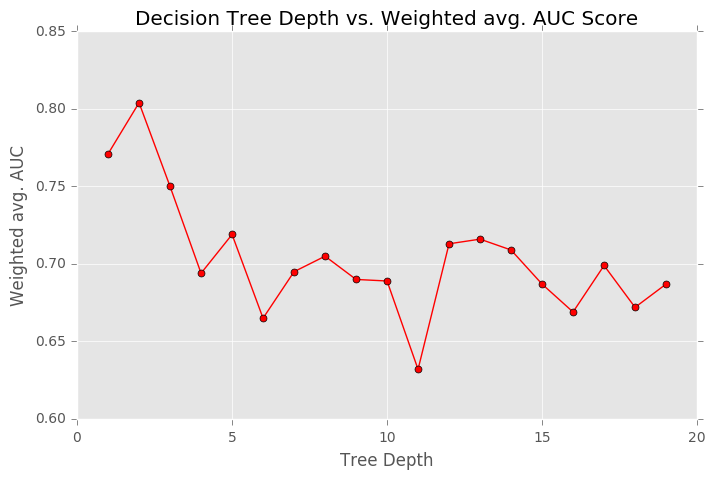

In [480]:
fig, ax = plt.subplots()
fig.set_size_inches(8,5)

ax.plot(range(1, 20), AUC, 'ro-', markersize=5)
ax.set_title('Decision Tree Depth vs. Weighted avg. AUC Score')    
ax.set_xlabel('Tree Depth')
ax.set_ylabel('Weighted avg. AUC')
plt.show()

##### PART C

In [498]:
# first, we hold out some true test data (20%)
X_mid, X_test, Y_mid, Y_test = train_test_split(X, Y, test_size=0.2)

# cross validation
AUC_valid = []
for j in range(1, 10):
    validation = []
    # do 50 iterations of validation at each hyper paramater value
    # NOTE: this is similar to k-fold validation, but both training and validation X and Y
    #        will overlap in domain through the iterations (bootstrapping)
    for i in range(50):
        # cross validation split (33%)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_mid, Y_mid, test_size=0.33)
        
        # fitting the tree at depth j
        tree = DTC(max_depth=j)
        tree.fit(X_train, Y_train)

        # get a prediction probability matrix for all classes
        prob_matrix = tree.predict_proba(X_valid)

        # NOTE - by calling 'tree.classes_', we know that the order of classes given by
        # the probability matrix matches that of the label matrix below

        # create a one-hot matrix for true labels
        label_df = pd.get_dummies(pd.DataFrame(Y_valid))
        label_matrix = label_df.as_matrix()

        # ROC-AUC scores are calculated for each class at the given complexity level
        # then, a weighted average of these class scores is used to measure the model fit overall
        validation.append(round(roc_auc_score(label_matrix, prob_matrix, average='weighted'), 3))
    
    # add the validation score to AUC, for a given hyper parameter value
    AUC_valid.append(np.mean(validation))

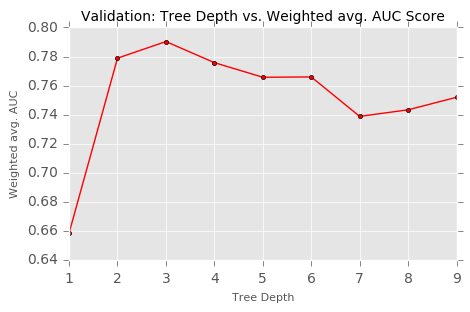

In [499]:
# now, let's TUNE the hyperparameter, based on validation data
fig, ax = plt.subplots()
fig.set_size_inches(5,3)

ax.plot(range(1, 10), AUC_valid, 'ro-', markersize=3)
ax.set_title('Validation: Tree Depth vs. Weighted avg. AUC Score', size=10)    
ax.set_xlabel('Tree Depth', size=8)
ax.set_ylabel('Weighted avg. AUC', size=8)
plt.show()

In [506]:
#finally, using the selected hyperparamter (3), we can test for accuracy on the test set

# we'll train this final model using all test and validation data, but not the held out test data
tree = DTC(max_depth=3)
tree.fit(X_mid, Y_mid)

prob_matrix = tree.predict_proba(X_test)
label_df = pd.get_dummies(pd.DataFrame(Y_test))
label_matrix = label_df.as_matrix()

print 'OS AUC Score:', round(roc_auc_score(label_matrix, prob_matrix, average='weighted'), 3)

OS AUC Score: 0.811


##### PART D

In [503]:
# similar to the lab, we'll just use the top three most important features from the above model
imp_df = pd.DataFrame([list(X_mid.columns), list(tree.feature_importances_)]).T
imp_df.columns = ["variables", "importance"]
imp_df = imp_df.sort_values(by="importance", ascending=False).iloc[:3,:]
imp_df

,variables,importance
11,GDPPCptaIntDol,0.356023
12,AdultLtrcyRate,0.275673
5,SustAccImprSanRur,0.206662


In [505]:
# reduce original train and test sets to only the three most important features
X_mid_simp = X_mid.loc[:,['GDPPCptaIntDol', 'AdultLtrcyRate', 'SustAccImprSanRur']]
X_test_simp = X_test.loc[:,['GDPPCptaIntDol', 'AdultLtrcyRate', 'SustAccImprSanRur']]

In [507]:
# fitting the simplified tree model, and limiting depth to 3
tree_simp = DTC(max_depth=3)
tree_simp.fit(X_mid_simp, Y_mid)

prob_matrix = tree_simp.predict_proba(X_test_simp)
label_df = pd.get_dummies(pd.DataFrame(Y_test))
label_matrix = label_df.as_matrix()

print 'Simplified model - OS AUC Score:', round(roc_auc_score(label_matrix, prob_matrix, average='weighted'), 3)

Simplified model - OS AUC Score: 0.839


In [508]:
# get order of tree classes, to use in argument below
tree_simp.classes_

array(['awful', 'high', 'low', 'medium'], dtype=object)

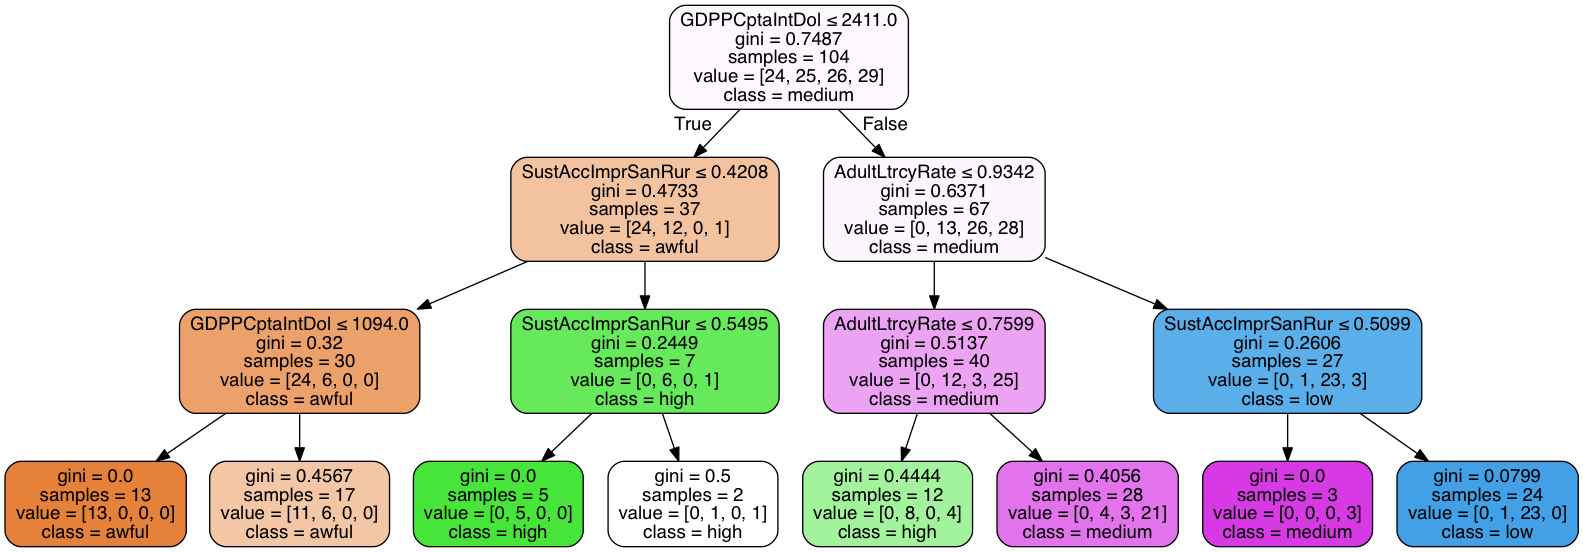

In [509]:
# visualizing tree, as demonstrated in lab
dot_data = StringIO()  
tree.export_graphviz(tree_simp, out_file=dot_data,  
                         feature_names=['GDPPCptaIntDol', 'AdultLtrcyRate', 'SustAccImprSanRur'],  
                         class_names=['awful', 'high', 'low', 'medium'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### Question 4, Fit a random forest to the data from question 3 (20 pts)

a) Please use the same test/train split from previous question and feel free to tune the hyper-parameters for Random Forest model using training data. The package from sklearn is here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.
Then please report your out of sample prediction result and compare this model's performance with 2c). (10 pts)

b) Write one paragraph comparing the results from those two models (Random Forest vs Decision Tree) in terms of both accuracy and interpretability. (10 pts)

In [510]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [511]:
# in fitting the forest, let's hold max_depth at 3 (tuned at the tree-level)
# but we'll vary the number of estimators
# theoretically, we'd expect AUC to always be higher with more estimators

# cross validation for random forest
AUC_valid = []
for j in range(10, 50, 2):
    validation = []
    # do 50 iterations of validation at each hyper paramater value
    # NOTE: this is similar to k-fold validation, but both training and validation X and Y
    #        will overlap in domain through the iterations (bootstrapping)
    for i in range(50):
        # cross validation split (33%)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_mid, Y_mid, test_size=0.33)
        
        # fitting the tree at depth j
        forest = RFC(max_depth=3, n_estimators=j)
        forest.fit(X_train, Y_train)

        # get a prediction probability matrix for all classes
        prob_matrix = forest.predict_proba(X_valid)

        # NOTE - by calling 'tree.classes_', we know that the order of classes given by
        # the probability matrix matches that of the label matrix below

        # create a one-hot matrix for true labels
        label_df = pd.get_dummies(pd.DataFrame(Y_valid))
        label_matrix = label_df.as_matrix()

        # ROC-AUC scores are calculated for each class at the given complexity level
        # then, a weighted average of these class scores is used to measure the model fit overall
        validation.append(round(roc_auc_score(label_matrix, prob_matrix, average='weighted'), 3))
    
    # add the validation score to AUC, for a given hyper parameter value
    AUC_valid.append(np.mean(validation))

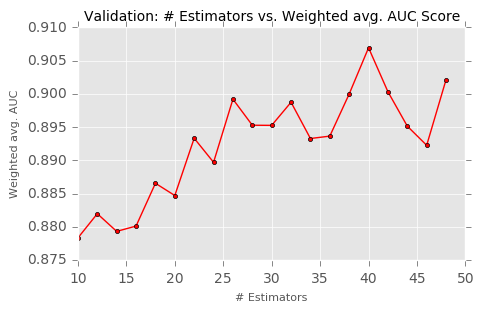

In [512]:
# now, let's TUNE the hyperparameter, based on validation data
# this will be a tradeoff between computing time and performance

fig, ax = plt.subplots()
fig.set_size_inches(5,3)

ax.plot(range(10, 50, 2), AUC_valid, 'ro-', markersize=3)
ax.set_title('Validation: # Estimators vs. Weighted avg. AUC Score', size=10)    
ax.set_xlabel('# Estimators', size=8)
ax.set_ylabel('Weighted avg. AUC', size=8)
plt.show()

In [513]:
# choosing n=25, because we see diminishing returns after that, while computing time continues to grow

# again train this final model using all test and validation data, but not the held out test data
forest = RFC(max_depth=3, n_estimators=25)
forest.fit(X_mid, Y_mid)

prob_matrix = forest.predict_proba(X_test)
label_df = pd.get_dummies(pd.DataFrame(Y_test))
label_matrix = label_df.as_matrix()

print 'OS AUC Score (Random Forest):', round(roc_auc_score(label_matrix, prob_matrix, average='weighted'), 3)

OS AUC Score (Random Forest): 0.874


We see marginal increases in model accuracy, from tree to random forest: AUC score of 0.811 for a single tree, and 0.874 for a random forest with 25 estimators. 

If high precision is of paramount importance, perhaps we'd select the forest over the tree, but at only 7% improvement in accuracy, one may consider using the tree model for the sake of interpretability. 

With that said, it's worth noting that even with a highly simplified tree, as we created in part D of Q3, the visual representation of the tree was quite complex - and that was with only 3 features. In the case of using many more features, a simpler way of achieving interpretability (and accuracy at the same time) is to use the random forest's 'feature importance' attribute. With this approach, we can focus on only the subgroup of features that have sufficient weight in the classifier.